In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
import scipy.stats as ss

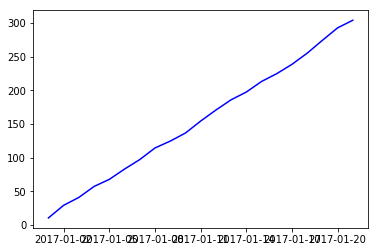

In [3]:
random.seed(111)
rng = pd.date_range(start='2017-01-01', end='2017-01-21', freq='D')
ts = pd.Series(np.random.uniform(10, 20, size=len(rng)), rng).cumsum()

z = np.arange(-100, 100)
xU, xL = z + 0.5, z - 0.5 
prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
prob = prob / prob.sum() #normalize the probabilities so their sum is 1
nums = np.random.choice(z, size = len(rng), p = prob)
ts2 = pd.Series(np.random.choice(z, size = len(rng), p = prob), rng).cumsum()

plt.plot(ts, c='b', label='b')
#plt.plot(ts2, c='r',label='a')

plt.show()

In [5]:
TS = np.array(ts)
TS2 = np.array(ts2)
num_periods = 20
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)

In [6]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

def test_data_2(series,forecast,num_periods):
    test_x_setup = TS2[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS2[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
#X_test, _ = test_data_2(TS2,f_horizon,num_periods )

In [7]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [8]:
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogatione
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})

(0, '\tMSE:', 585183.44)
(100, '\tMSE:', 1780.7832)
(200, '\tMSE:', 859.7196)
(300, '\tMSE:', 612.70654)
(400, '\tMSE:', 486.681)
(500, '\tMSE:', 419.28888)
(600, '\tMSE:', 365.15305)
(700, '\tMSE:', 308.82068)
(800, '\tMSE:', 248.93018)
(900, '\tMSE:', 176.91293)


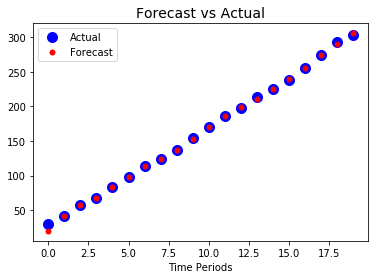

In [9]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

In [31]:
df1 = pd.DataFrame({'x':pd.Series(np.ravel(Y_test))})
df2=  pd.DataFrame({'y':pd.Series(np.ravel(y_pred))})
print ss.pearsonr(df1['x'], df2['y'])

(0.8806164676733742, 3.010198608565851e-07)
